# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [206]:
# System imports
from os import path
import math
import copy
# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# # modify to where you store your project data including utils
# datadir = "/content/drive/My Drive/cs445_projects/proj4/" 

# utilfn = datadir + "utils"
# !cp -r "$utilfn" .
# samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .

# # can change this to your output directory of choice
# !mkdir "images"
# !mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

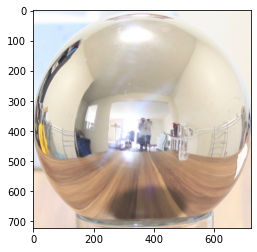

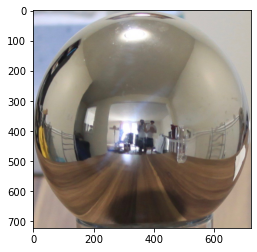

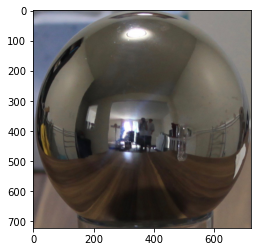

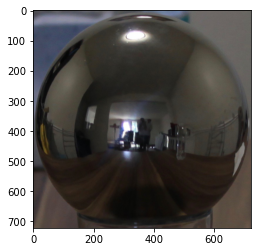

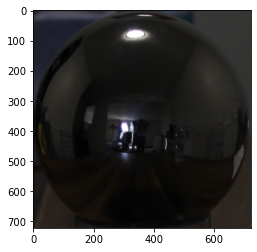

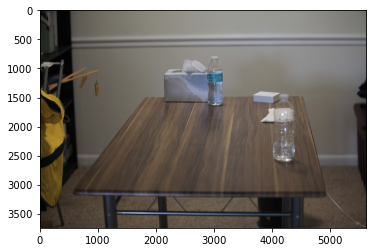

In [207]:
# TODO: Replace this with your path and files

# imdir = 'samples'
imdir = 'mysample'
imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]
# imfns = ['0024.jpg', '0060.jpg', '0120.jpg']
# exposure_times = [1/24.0, 1/60.0, 1/120.0]
ldr_images = []
for f in np.arange(len(imfns)):
    im = read_image(imdir + '/' + imfns[f])
    if f==0:
        imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
        ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
        
    ldr_images[f] = cv2.resize(im, (imsize, imsize))
    plt.imshow(ldr_images[f])
    plt.show() 

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)

plt.imshow(background_image)
plt.show() 

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [5]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''

    img_out_log = np.zeros(im_hdr.shape)
    new_im_hdr = im_hdr
    im_out_log = np.log(new_im_hdr)
    log_min = im_out_log[im_out_log != -float('inf')].min()
    log_max =im_out_log[im_out_log != float('inf')].max()
#     print("log_min", log_min)
#     print("log_max", log_max)
    im_out_log[im_out_log == float('inf')] = log_max
    im_out_log[im_out_log == -float('inf')] = log_min
    im_out_log = (im_out_log - log_min) / (log_max - log_min)
    plt.imshow(im_out_log)
    plt.show() 
    
    
    return


In [343]:
def make_hdr_naive(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
  
    hdr_image = np.zeros(ldr_images[0,:,:,:].shape)
#     print("ldr_images.shape",ldr_images.shape)
#     print("ldr_images[0,:,:,:].shape", ldr_images[0,:,:,:].shape)
    log_irradiances = np.zeros(ldr_images.shape)

    for i in range(N):
#         exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]
        log_irradiances[i,:,:,:] = np.log((ldr_images[i,:,:,:] + 0.00001)/(exposure_times[i]+0.000001))
        hdr_image += ldr_images[i,:,:,:]
    hdr_image /= 5
    
    
  
    return hdr_image, log_irradiances



HDR Image


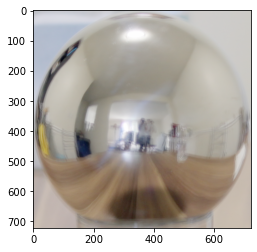

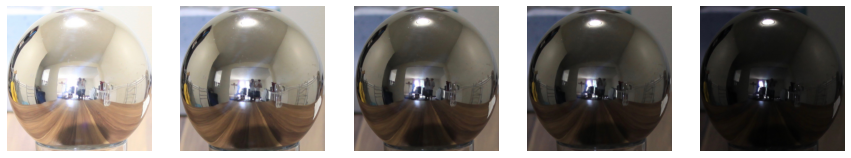

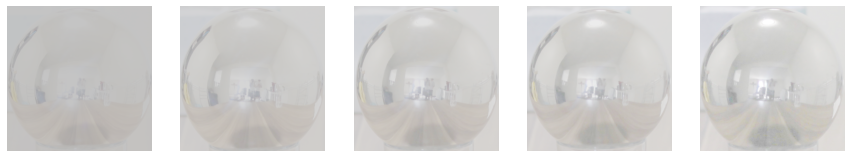

In [344]:
# for i in range(5):
#     plt.imshow(ldr_images[i])
#     plt.show()
# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr_Divide.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [351]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)
    hdr_image = np.zeros(ldr_images[0,:,:,:].shape)
    local_images = copy.deepcopy(ldr_images)
    m = np.zeros((N,H,W,C))
#     print(np.amax(local_images))
#     print(np.amin(local_images))
    for i in range(N):
        hdr_img_loop = (local_images[i,:,:,:]+0.00001)/(exposure_times[i]+0.0001)
        filt = (128-abs(local_images[i,:,:,:]-128))
#         print("np.amax(filt)", np.amax(filt))
#         print("np.amin(filt)",np.amin(filt))

#         plt.imshow(filt)
#         plt.show()

        m[i,:,:,:] = filt
        
        hdr_image += hdr_img_loop * filt
    hdr_image = hdr_image / np.sum(m, axis=0)
    hdr_image /= N

    return hdr_image


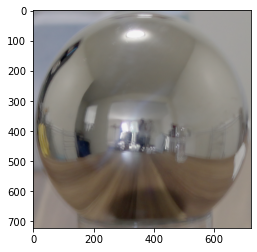

In [352]:
# for i in range(5):
#     plt.imshow(ldr_images[i])
#     plt.show()
# # get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)


# # # # write HDR image to directory
# write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr_nov9.hdr')

# # display HDR image
display_hdr_image(weighted_hdr_image)


Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

1.0
42.889143298562296
Min ratio =  13.542111978566258   Max ratio =  100.95115007448342


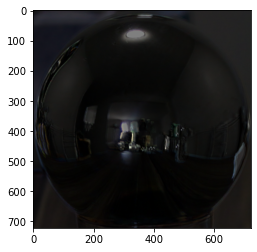

In [353]:
# display difference between naive and weighted 
print(np.amax(naive_hdr_image))
print(np.amax(weighted_hdr_image))
log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [355]:
import random
def new_make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
   #init variables 
    local_ldr_images = copy.deepcopy(ldr_images)
    local_ldr_images = (local_ldr_images * 255).astype(int)
#     for i in range(5):
#         plt.imshow(local_ldr_images[i])
#         plt.show() 
    N, H, W, C = local_ldr_images.shape
    hdr_image = np.zeros(local_ldr_images[0,:,:,:].shape)
    log_irradiances = np.zeros(local_ldr_images.shape)
    random_total = 5000
#     create a circle mask
    circle_mask = np.ones((H, W))
    for i in range(H):
        for j in range(W):
            if (H/2 - i)**2 + (W/2 - j)**2 > (H/2)**2:
                circle_mask[i, j] = 0
#     plt.imshow(circle_mask)
#     plt.show() 
#pick random pixels from the circle, N pictures
    circle_h, circle_w = np.where(circle_mask == 1)
    random_h = []
    random_w = []
    for rand in range(random_total):
        local_rand = random.randint(0, len(circle_w))
        random_h.append(circle_h[local_rand]) 
        random_w.append(circle_w[local_rand]) 
    
#     Z = np.zeros((N,total_random))
#     B = np.log(exposure_times)
#     l = lm
#     w = lambda z: float(128-abs(z-128))
#     g_values = np.zeros((C,256))
    B = np.log(exposure_times)
    l = lm
    w = lambda z: (128-abs(z-128))
    g_val = []
    
    ##use gsolve 
    for c in range(C):
        Z = np.zeros((N, random_total), dtype=int)
        for img_num in range(N):
            loop_ldr = copy.deepcopy(local_ldr_images[img_num])
            Z[img_num] = loop_ldr[random_h, random_w, c]
        g, le = gsolve(Z, B, l, w)
        g_val.append(g)

        hdr_weights = []
        for img_num,(loop_ldr,log_expo) in enumerate(zip(local_ldr_images,B)):
            cur_ldr = loop_ldr[:,:,c]
#             hdr_image[:,:,c]+=w(cur_ldr).astype(float)*(g[cur_ldr]-log_expo)
            hdr_image[:,:,c]+=w(cur_ldr).astype(float)*(g[cur_ldr]-log_expo).astype(float)
            hdr_weights.append(w(cur_ldr).astype(float))
            log_irradiances[img_num,:,:,c]=(g[cur_ldr]-log_expo)
        hdr_image[:,:,c]/=np.sum(hdr_weights,axis=0).astype(float)
    hdr_image = np.exp(hdr_image)
    return hdr_image, log_irradiances, np.asarray(g_val)


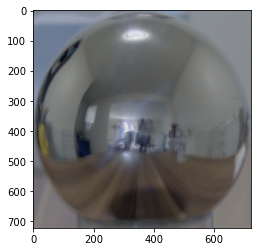

In [356]:
lm = 3000
# get HDR image, log irradiance
# calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation_2(ldr_images, exposure_times, lm)
calib_hdr_image, calib_log_irradiances, g = new_make_hdr_estimation(ldr_images, exposure_times, lm)



# # write HDR image to directory
# write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdrHi.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)


The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.0814276951988353   Max ratio =  4.865780006263132


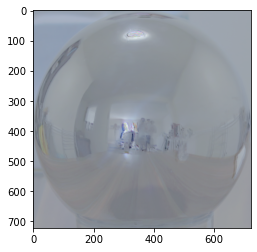

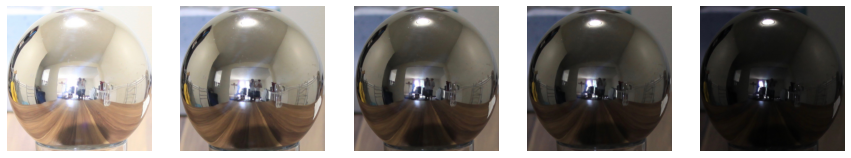

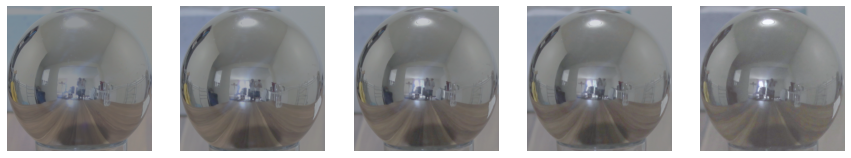

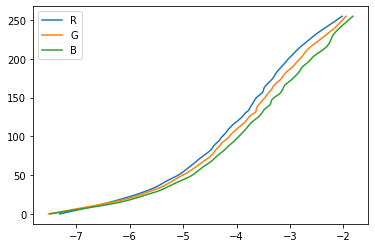

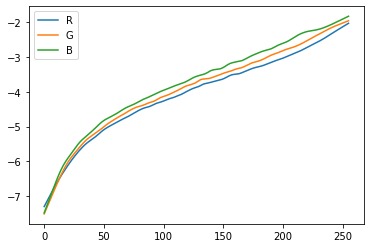

In [357]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  2.755 	avg RMS error =  4.574
weighted:	log range =  3.878 	avg RMS error =  1.814
calibrated:	log range =  5.828 	avg RMS error =  0.188


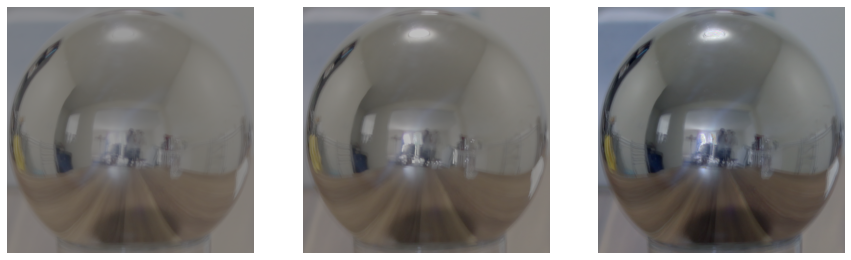

In [358]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
    N, H, W, C = ldr_images.shape
    w = 1-abs(ldr_images - 0.5)*2
    err = 0
    for n in np.arange(N):
        err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
    return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [192]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    h_h, h_w = H/2, W/2 #half of the origin
    assert H == W
    assert C == 3

    N = np.zeros((H,W,C))

    for i in range(H):
        for j in range(W):
            if((i-h_h)**2 + (j-h_w)**2 > h_h**2):
                N[j][i] = (0,0,0)
                continue
            Nx = (j - h_w)/ h_w
            Ny = (i - h_h)/ h_h
            Nz = np.sqrt(1 -  Ny**2 - Nx**2 )
            if(Nz == float("NaN")):
                Nz = 0
            N[i][j] = (Nx, Ny, Nz)
    # R = V - 2 * dot(V,N) * N
#     V = [0,0,1]
    V= np.array([0,0,-1])
    R = np.zeros((H,W,C))
    for i in range(H):
        for j in range(W):
            # R = V - 2 * dot(V,N) * N
            R[j][i] = V - 2 * np.dot(V,N[j][i]) * N[j][i]
    plt.imshow((N+1)/2)
    plt.show()
    plt.imshow((R+1)/2)
    plt.show()
    equirectangular_image = get_equirectangular_image(R, hdr_image)
    return equirectangular_image


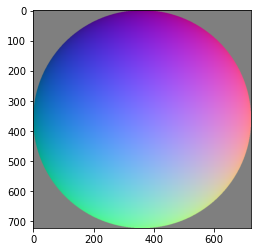

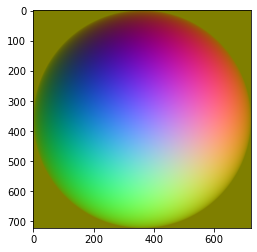

/Users/MedicalDoctor/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


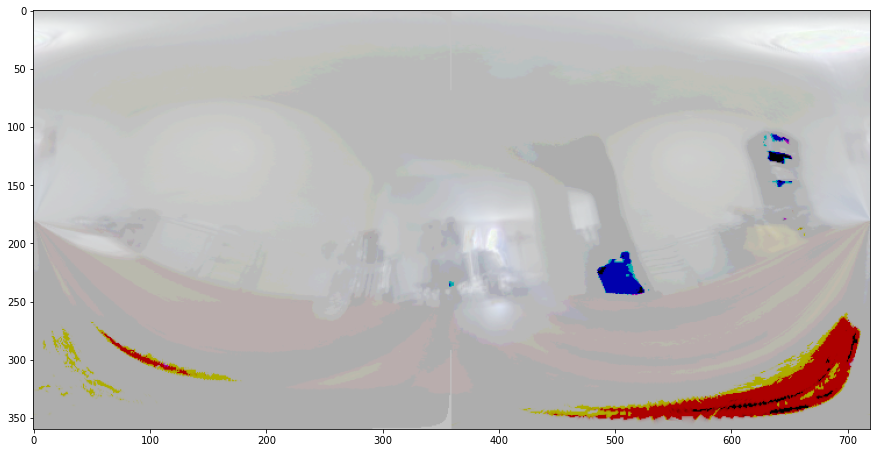

In [194]:
# hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdrHi.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular2.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

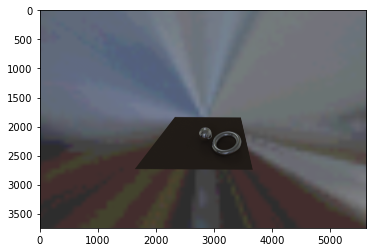

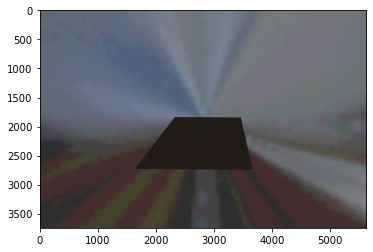

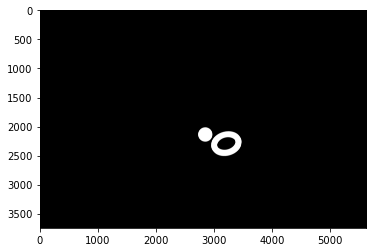

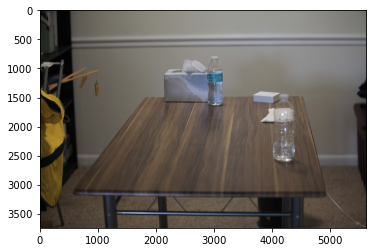

In [200]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image('images/proj4_objects02.png')
E = read_image('images/proj4_empty02.png')
M = read_image('images/proj4_mask02.png')
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))
plt.imshow(O)
plt.show()
plt.imshow(E)
plt.show()
plt.imshow(M.astype('double'))
plt.show()
plt.imshow(I)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


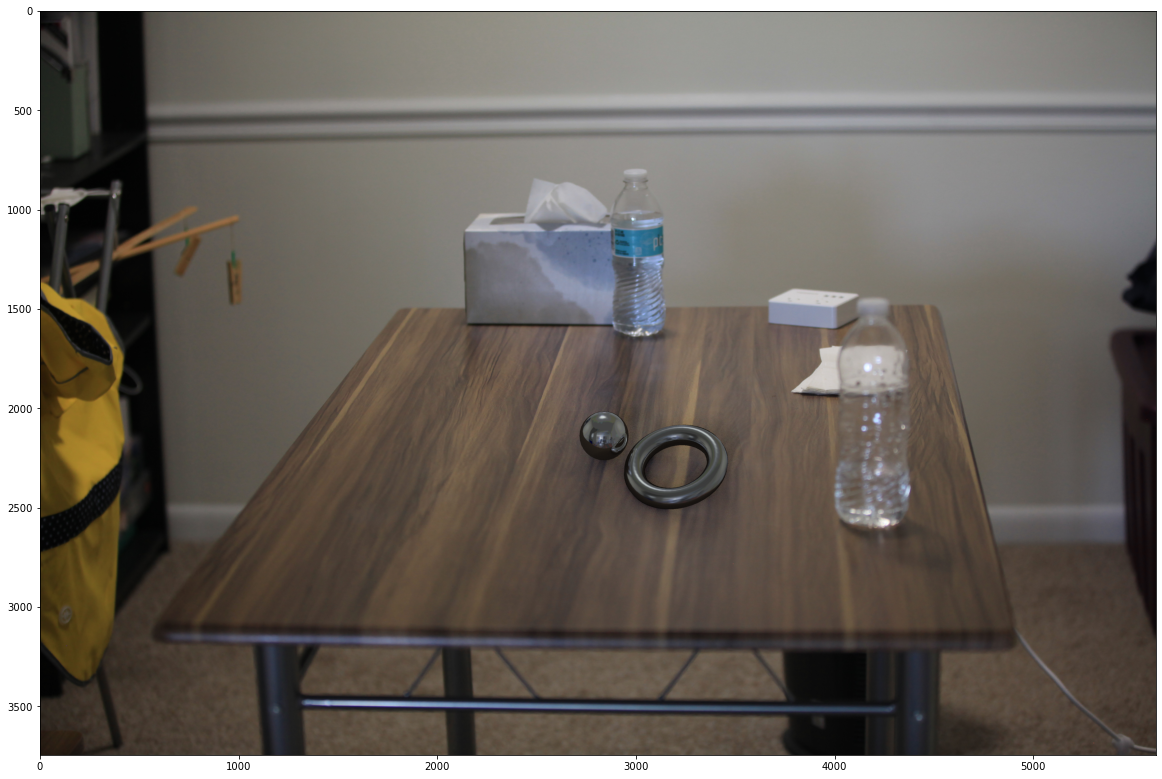

In [205]:
# TO DO: compute final composite
# composite = M*R + (1-M)*I + (1-M)*(R-E)*c
result = []
c=4
result = M*O + (1-M)*I + (1-M)*(O-E)*c

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_compositelargeC.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 

